# Costream Package: End-to-End Pipeline Test

This notebook demonstrates the full workflow of the `costream` package:
1. **Data Loading**: Loading subject CSVs and calculating features (Magnitude).
2. **Training Prep**: Segmenting data into Windows (X, y) for training.
3. **Modeling**: Training the `CostClassifierCV` with threshold optimization.
4. **Evaluation**: Running streaming inference on held-out test subjects.
5. **Visualization**: Plotting confidence maps and metrics.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# --- Costream Imports ---
from costream.data import make_csv_loader, group_files_by_subject
from costream.segmentation import create_training_data
from costream.model import CostClassifierCV
from costream.evaluation import run_experiment, ModelSpec
from costream.evaluation.visualization import (
    metric_box, 
    plot_confidence, 
    plot_grouped_stacked, 
    set_style
)

## 1. Setup Data

We will generate synthetic "accelerometer" data that mimics falls to ensure this notebook runs out-of-the-box.
**To use real data:** Skip the generation block and point `DATA_DIR` to your CSV folder.

In [2]:
FREQ = 100  # Hz
DATA_DIR = "../data/falls"
data_desc = pd.read_excel("../data/description.xlsx", engine='openpyxl',
                          usecols=['Randomnumber', 'Sensor_location', 'Sample_rate_Hz'])
l5 = data_desc[data_desc['Sensor_location'] == 'L5']
l5 = l5[l5['Sample_rate_Hz'] == FREQ]
l5_subjects = set(l5['Randomnumber'].str.split('-').str[0])
l5[l5['Sample_rate_Hz'] != FREQ]
len(l5_subjects)

54

## 2. Data Loading

We define a feature extractor to calculate Vector Magnitude (`mag`) on the fly during loading.

In [3]:
# Define feature engineering logic
def calculate_magnitude(df):
    raw_mag = np.sqrt(df['acc_x']**2 + df['acc_y']**2 + df['acc_z']**2)
    return raw_mag / 9.81  # Convert to g-units

# Create the loader function
load_subject = make_csv_loader(
    feature_cols=['mag'],       # We only want 'mag' for training
    label_col='label',
    new_features={'mag': calculate_magnitude} # How to create 'mag'
)

def id_extractor(p: str) -> str:
	name = os.path.splitext(os.path.basename(p))[0]
	s = name.split('-')[0].split('_')[1]
	return s

# 1. Group files
subject_map = group_files_by_subject(DATA_DIR, id_extractor=id_extractor)
# Limit to subjects with 'L5' data only
subject_map = {s: fps for s, fps in subject_map.items() if s in l5_subjects}
all_subjects = list(subject_map.keys())
print(f"Found {len(all_subjects)} subjects: {all_subjects[:3]} ...")

# 2. Split Subjects into Train / Test
train_subjs, test_subjs = train_test_split(all_subjects, test_size=0.2, random_state=42)
print(f"Train Subjects: {len(train_subjs)}")
print(f"Test Subjects:  {len(test_subjs)}")

# 3. Load DataFrames
# Flatten the list of lists:
# For each subject 's', get every file 'f' in subject_map[s]
train_files = [f for s in train_subjs for f in subject_map[s]]
test_files  = [f for s in test_subjs  for f in subject_map[s]]

print(f"Total Training Files: {len(train_files)}")  # Should be ~124
print(f"Total Test Files:     {len(test_files)}")   # Should be ~21

# Now load them
train_dfs = load_subject(train_files)
test_dfs  = load_subject(test_files)

Found 40 subjects: ['93807530', '79336438', '18194920'] ...
Train Subjects: 32
Test Subjects:  8
Total Training Files: 113
Total Test Files:     34


In [4]:
len(train_dfs), len(test_dfs)

(113, 34)

## 3. Segmentation (Training Data)

We convert the continuous `train_dfs` into windowed segments `X` and labels `y`.

In [5]:
X_train, y_train = create_training_data(
    train_dfs,
    feature_cols=['mag'],
    window_size=10,   # 10 second windows
    step=1.0,          # 1 second step for negatives
    freq=FREQ,
    activity_threshold=1.4, # Threshold for real data
    drop_below_threshold=True,
    spacing="multiphase"         
)

# Flatten input: (N, Win, 1) -> (N, Win) for sklearn
if X_train.ndim == 3:
    X_train = X_train[:, :, 0]

print(f"Training Data Shape: X={X_train.shape}, y={y_train.shape}")
print(f"Class Balance: {np.bincount(y_train)} (0=ADL, 1=Fall)")

Training Data Shape: X=(1826, 1000), y=(1826,)
Class Balance: [1714  112] (0=ADL, 1=Fall)


## 4. Define and Train Models

We will compare a standard Logistic Regression against **CostClassifierCV**.

In [11]:
# --- Fixed Random State for Reproducibility ---
SEED = 42

# A. Individual Models
# Default Logistic Regression 
default_lr = LogisticRegression(
    solver='liblinear',  
    random_state=SEED 
)

# Logistic Regression with Cost-Sensitive Learning
cost_sensitive_lr = CostClassifierCV(
    base_estimators=[
        LogisticRegression(solver='liblinear', random_state=SEED)
    ],
    random_state=SEED
)

# Default Random Forest
default_rf = RandomForestClassifier(
    n_estimators=150,
    random_state=SEED
)

# Random Forest with Cost-Sensitive Learning
cost_sensitive_rf = CostClassifierCV(
    base_estimators=[
        RandomForestClassifier(n_estimators=150, random_state=SEED)
    ],
    random_state=SEED
)

# B. Cost-Sensitive Ensembles
# Stacked ensemble of both LR and RF with Cost-Sensitive Learning
cost_model_stacked = CostClassifierCV(
    base_estimators=[
        LogisticRegression(solver='liblinear', random_state=SEED), 
        RandomForestClassifier(n_estimators=150, random_state=SEED)
    ],
    method='stacking',
    random_state=SEED 
)
# dirichlet ensemble of both LR and RF with Cost-Sensitive Learning
cost_model_dirichlet = CostClassifierCV(
    base_estimators=[
        LogisticRegression(solver='liblinear', random_state=SEED), 
        RandomForestClassifier(n_estimators=150, random_state=SEED)
    ],
    method='dirichlet',
    random_state=SEED 
)

specs = [
    ModelSpec("LR_Baseline", default_lr),
    ModelSpec("Cost_Sensitive_LR", cost_sensitive_lr),
    ModelSpec("RF_Baseline", default_rf),
    ModelSpec("Cost_Sensitive_RF", cost_sensitive_rf),
    ModelSpec("Cost_Sensitive_Ensemble_Stacked", cost_model_stacked),
    ModelSpec("Cost_Sensitive_Ensemble_Dirichlet", cost_model_dirichlet)
]

## 5. Run Streaming Evaluation

The `run_experiment` function handles:
1. Training the models on `X_train`.
2. Running sliding window inference on raw `test_dfs`.
3. Detecting events and calculating metrics (TP, FP, Delay).

In [12]:
# Prepare Test Data: Extract raw signals and ground truth event points
test_signals = [df['mag'].values for df in test_dfs]

# Find the index where label == 1 (Fall Point), or -1 if no fall
test_events = []
for df in test_dfs:
    falls = np.where(df['label'] > 0)[0]
    test_events.append(falls[0] if len(falls) > 0 else -1)

# Run the Engine
results_df = run_experiment(
    X_train, y_train,
    test_signals=test_signals,
    test_event_points=test_events,
    model_specs=specs,
    window_size=10,
    step=1.0,           # Slide by 1s during testing
    freq=FREQ,
    tolerance=20,      # Allow 20s margin for correct detection
    ensemble_all=False,
    verbose=True
)

# Show Results
print("\n--- Evaluation Results ---")
display(results_df)

TRAINING 6 models on 1826 samples...
  ✓ LR_Baseline trained in 0.14s
  ✓ Cost_Sensitive_LR trained in 1.21s
  ✓ RF_Baseline trained in 3.69s
  ✓ Cost_Sensitive_RF trained in 27.39s
  ✓ Cost_Sensitive_Ensemble_Stacked trained in 28.89s
  ✓ Cost_Sensitive_Ensemble_Dirichlet trained in 70.66s

TESTING on 34 recordings (Window=10s)...
  Evaluating LR_Baseline... Done.
  Evaluating Cost_Sensitive_LR... Done.
  Evaluating RF_Baseline... Done.
  Evaluating Cost_Sensitive_RF... Done.
  Evaluating Cost_Sensitive_Ensemble_Stacked... Done.
  Evaluating Cost_Sensitive_Ensemble_Dirichlet... Done.

--- Evaluation Results ---


,model,runtime,delay,precision,recall,specificity,f1-score,auc,false alarm rate,miss rate,gain,thresh
0,LR_Baseline,0.012731,-0.676471,0.838710,0.764706,0.999875,0.800000,0.882290,0.044634,0.071414,-0.187462,0.500000
1,Cost_Sensitive_LR,0.026502,-0.617647,0.827586,0.705882,0.999875,0.761905,0.852879,0.044634,0.089268,-0.223169,0.454545
2,RF_Baseline,0.044230,-0.905000,0.805556,0.852941,0.999825,0.828571,0.926383,0.062487,0.044634,-0.151755,0.500000
3,Cost_Sensitive_RF,0.116021,-1.250882,0.711111,0.941176,0.999675,0.810127,0.970426,0.116048,0.017854,-0.151755,0.262626
4,Cost_Sensitive_Ensemble_Stacked,0.135520,-1.039412,0.738095,0.911765,0.999725,0.815789,0.955745,0.098195,0.026780,-0.151755,0.292929
5,Cost_Sensitive_Ensemble_Dirichlet,0.136765,-3.721471,0.400000,1.000000,0.998724,0.571429,0.999362,0.455266,0.000000,-0.455266,0.020202


## 6. Visualization

Let's inspect the performance.

/Users/timilehin/code/costream/costream/evaluation/visualization.py:72: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/Users/timilehin/code/costream/costream/evaluation/visualization.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


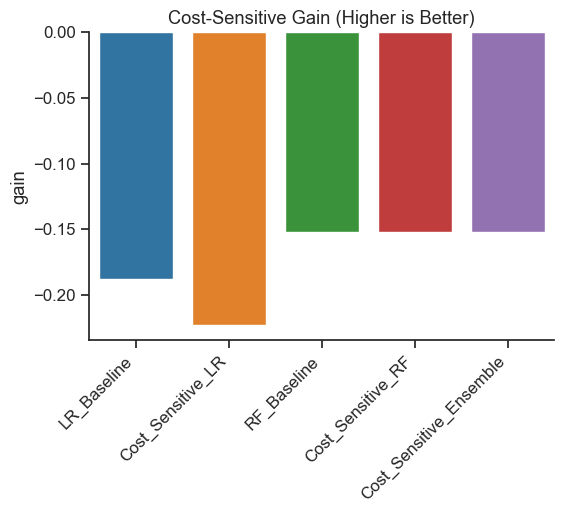

/Users/timilehin/code/costream/costream/evaluation/visualization.py:72: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(
/Users/timilehin/code/costream/costream/evaluation/visualization.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


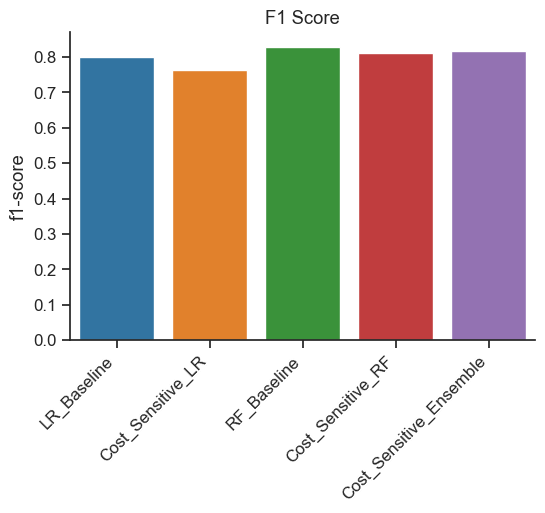

In [10]:
# 1. Boxplot of Cost/Gain
plt.figure(figsize=(6, 4))
metric_box(results_df, "gain", title="Cost-Sensitive Gain (Higher is Better)", type="bar")
plt.show()

# 2. Boxplot of F1-Score
plt.figure(figsize=(6, 4))
metric_box(results_df, "f1-score", title="F1 Score", type="bar")
plt.show()

### Visualize a Specific Trace
Let's plot the confidence map for one of the Fall subjects in the test set.

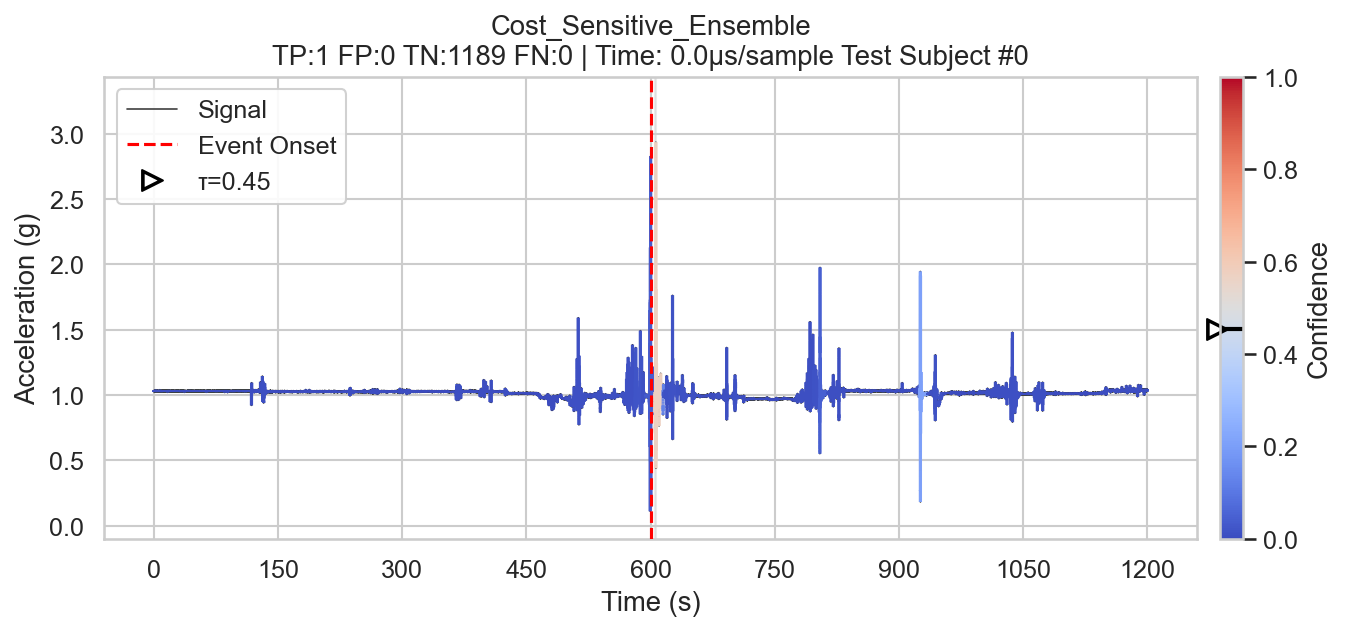

In [9]:
# Pick a model to visualize
model_name = "Cost_Sensitive_Ensemble"

# Find a subject that actually has a fall
fall_idx = next(i for i, x in enumerate(test_events) if x != -1)
signal = test_signals[fall_idx]
event_pt = test_events[fall_idx]

# Manually run inference for visualization
# (In a real app, you would load the trained model from disk)
# We access the trained instance implicitly or retrain quickly for viz:
trained_model = specs[1].estimator.fit(X_train, y_train) 
thresh = getattr(trained_model, "threshold_", 0.5)

from costream.segmentation.streaming_segmenter import sliding_window_inference

conf_map, runtime = sliding_window_inference(
    signal, trained_model, 
    window_size=10, step=1.0, freq=FREQ
)

# Calculate stats for the title
from costream.evaluation.event_detection import evaluate_recording
cm, highs, _ = evaluate_recording(len(signal), event_pt, conf_map, confidence_thresh=thresh, window_size=10)
tn, fp, fn, tp = cm.ravel()

plot_confidence(
    signal, conf_map, event_pt,
    tp, fp, tn, fn,
    high_conf=highs,
    model_name=model_name,
    thresh_line=thresh,
    freq=FREQ,
    title=f"Test Subject #{fall_idx}"
)

## 7. Cleanup
Remove the temporary synthetic data folder.

In [10]:
# shutil.rmtree(DATA_DIR)
# print("Cleaned up temp data.")